## Try different Boosting models to get better predictions

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('../common')

from print_more_stuff import print_more_stuff
from regression_models import dosomething
from preprocessing import mean_and_std

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
outliers_df = pd.read_csv("geocoded.csv")
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7614 entries, 0 to 7613
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    7614 non-null   int64  
 1   bed             7614 non-null   float64
 2   bath            7614 non-null   float64
 3   acre_lot        7614 non-null   float64
 4   zip_code        7614 non-null   float64
 5   house_size      7614 non-null   float64
 6   prev_sold_date  7614 non-null   object 
 7   price           7614 non-null   float64
 8   prev_sold_year  7614 non-null   int64  
 9   zip_code_str    7614 non-null   int64  
 10  latitude        7614 non-null   float64
 11  longitude       7614 non-null   float64
 12  county          7614 non-null   int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 773.4+ KB


In [4]:
outliers_df.head()

,Unnamed: 0.1,bed,bath,acre_lot,zip_code,house_size,prev_sold_date,price,prev_sold_year,zip_code_str,latitude,longitude,county
0,0,3.0,2.0,0.14,7001.0,1542.0,2022-01-27,305100.0,2022,7001,40.582316,-74.271506,12
1,1,3.0,2.0,0.11,7001.0,1500.0,2016-12-21,479000.0,2016,7001,40.582316,-74.271506,12
2,2,3.0,2.0,0.17,7001.0,7501.0,2021-11-01,340000.0,2021,7001,40.582316,-74.271506,12
3,3,5.0,2.0,0.18,7001.0,1387.0,2020-12-22,484000.0,2020,7001,40.582316,-74.271506,12
4,4,3.0,2.0,0.17,7001.0,1500.0,2019-05-28,425000.0,2019,7001,40.582316,-74.271506,12


#### Find the zip code of that has the most houses.

In [5]:
groupby_zipcode = outliers_df.groupby(["zip_code"])["zip_code"].count().sort_values(ascending=False)
groupby_zipcode_df = pd.DataFrame(groupby_zipcode).rename(columns={"zip_code":"count"}).reset_index()
first_zipcode = groupby_zipcode_df.iloc[0]["zip_code"]
first_zipcode

8260.0

#### Find the rows of the zip code that has the most houses.

In [6]:
one_zipcode_df = outliers_df[outliers_df["zip_code"].isin([first_zipcode])]

In [7]:
one_zipcode_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 7066 to 7248
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    183 non-null    int64  
 1   bed             183 non-null    float64
 2   bath            183 non-null    float64
 3   acre_lot        183 non-null    float64
 4   zip_code        183 non-null    float64
 5   house_size      183 non-null    float64
 6   prev_sold_date  183 non-null    object 
 7   price           183 non-null    float64
 8   prev_sold_year  183 non-null    int64  
 9   zip_code_str    183 non-null    int64  
 10  latitude        183 non-null    float64
 11  longitude       183 non-null    float64
 12  county          183 non-null    int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 20.0+ KB


#### Create an object to pass to the function that will normalize the data

In [8]:
params = {
    "data":one_zipcode_df,
    "features_a":["prev_sold_year","latitude","longitude","zip_code"],
    "features_n":["bed","bath","acre_lot","house_size","price"]
}
normalize_df = mean_and_std(params)
normalize_df.tail()

,bed,bath,acre_lot,house_size,price,prev_sold_year,latitude,longitude,zip_code
7244,-0.82102,-1.083472,0.216191,-1.368403,-0.931623,2018,38.998468,-74.843447,8260.0
7245,-0.82102,-1.083472,0.216191,-1.625842,-0.993673,2022,38.998468,-74.843447,8260.0
7246,-1.64204,-1.083472,0.216191,0.080097,-0.993363,2022,38.998468,-74.843447,8260.0
7247,0.82102,0.710875,0.216191,0.080097,0.448989,2022,38.998468,-74.843447,8260.0
7248,-0.82102,-0.186298,0.216191,0.075209,-0.373173,2017,38.998468,-74.843447,8260.0


#### Create a variable for the correlation of the normalized data

In [9]:
correlation = normalize_df[["acre_lot","bed","bath","house_size","prev_sold_year","price"]].corr()
correlation["price"]

acre_lot         -0.022765
bed               0.643951
bath              0.801066
house_size        0.669718
prev_sold_year   -0.056514
price             1.000000
Name: price, dtype: float64

#### Display a Heatmap with the correlated data

Text(0.5, 1.0, 'Correlation Between Variables')

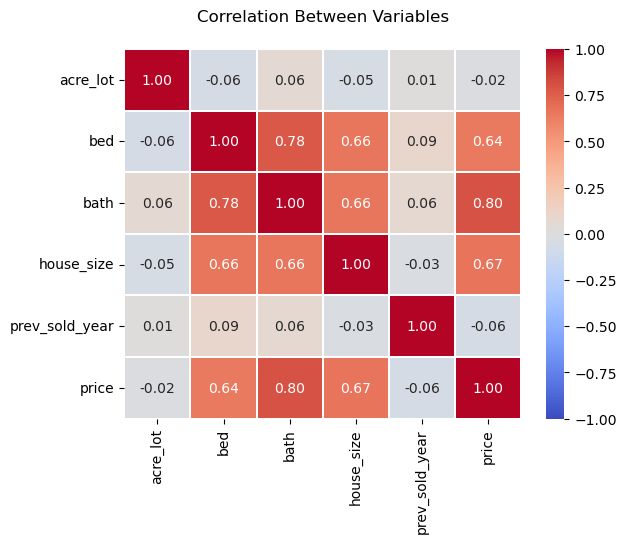

In [10]:
sns.heatmap(correlation, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)
plt.title("Correlation Between Variables", pad=20)

#### Create a variable to hold the features that correlate with the price feature between 0.20 and 0.80

In [11]:
'''
'''
savefeatures = ["latitude","longitude"]
for feature, value in correlation["price"].items():
    if abs(value) < 0.81 and abs(value) >= 0.20:
        savefeatures.append(feature)

print(savefeatures)

['latitude', 'longitude', 'bed', 'bath', 'house_size']


#### Create common variables to store frequently used values.

In [12]:
#features = ["latitude","longitude","bed","bath","house_size"]
features = savefeatures
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [13]:
X = normalize_df[savefeatures]
y = normalize_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [14]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [15]:
def results_dict_append(rtnval):
    results_dict["model"].append(rtnval["model"])
    results_dict["explained variance score"].append(rtnval["explained variance score"])
    results_dict["mae score"].append(rtnval["mae score"])
    results_dict["mse score"].append(rtnval["mse score"])
    results_dict["r2 score"].append(rtnval["r2 score"])
    results_dict["mean fit time"].append(rtnval["mean fit time"])

#### Ada Boosting

In [16]:
adaboost = dosomething("Ada Boost","Ada Boost", normalize_df, features, "price")
results_dict_append(adaboost["results"])
adaboost_predict = adaboost["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size']
Ada Boost EVS = 0.555359463
Ada Boost MSE = 0.500958
Ada Boost MAE = 0.497237
Ada Boost R2 = 0.548978
Ada Boost Fit Time = 0.008153247833251952


#### Gradient Boosting

In [17]:
gbr = dosomething("Gradient Boosting","Gradient Boosting", normalize_df, features, "price")
results_dict_append(gbr["results"])
gbr_predict = gbr["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size']
Gradient Boosting EVS = 0.632650045
Gradient Boosting MSE = 0.408047
Gradient Boosting MAE = 0.441327
Gradient Boosting R2 = 0.632628
Gradient Boosting Fit Time = 0.02642989158630371


#### Hist Gradient Boosting

In [18]:
histgbr = dosomething("Hist Gradient Boosting","Hist Gradient Boosting", normalize_df, features, "price")
results_dict_append(histgbr["results"])
histgbr_predict = histgbr["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size']
Hist Gradient Boosting EVS = 0.543123573
Hist Gradient Boosting MSE = 0.510044
Hist Gradient Boosting MAE = 0.480300
Hist Gradient Boosting R2 = 0.540798
Hist Gradient Boosting Fit Time = 0.08887925148010253


#### Random Forest

In [19]:
rf = dosomething("Random Forest","Random Forest", normalize_df, features, "price")
results_dict_append(rf["results"])
rf_predict = rf["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size']
Random Forest EVS = 0.660194370
Random Forest MSE = 0.378796
Random Forest MAE = 0.416642
Random Forest R2 = 0.658963
Random Forest Fit Time = 0.08249411582946778


#### Graphing the results works best when the data is provided in a DataFrame.

In [20]:
adaboost_predict_df = pd.DataFrame(adaboost_predict).reset_index()
adaboost_predict_df.rename(columns={0: "prediction"},inplace=True)

gbr_predict_df = pd.DataFrame(gbr_predict).reset_index()
gbr_predict_df.rename(columns={0: "prediction"},inplace=True)

rf_predict_df = pd.DataFrame(rf_predict).reset_index()
rf_predict_df.rename(columns={0: "prediction"},inplace=True)

histgbr_predict_df = pd.DataFrame(histgbr_predict).reset_index()
histgbr_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

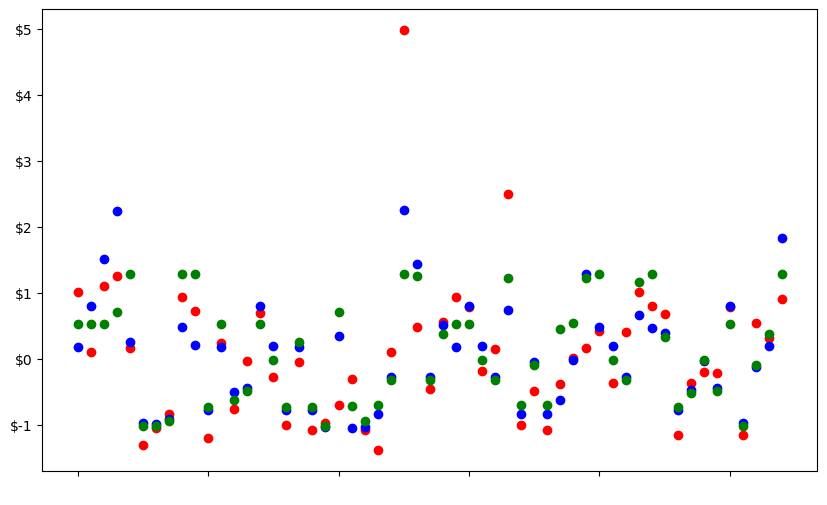

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(gbr_predict_df.index,gbr_predict_df["prediction"], color="blue")
plt.scatter(histgbr_predict_df.index,histgbr_predict_df["prediction"], color="green")
#plt.scatter(adaboost_predict_df.index,adaboost_predict_df["prediction"], color="black")
#plt.scatter(rf_predict_df.index,rf_predict_df["prediction"], color="black")
plt.show()

#### Output the results so they can be copied into another Notebook comparing the results of all the models.

In [22]:
results_dict

{'model': ['Ada Boost',
  'Gradient Boosting',
  'Hist Gradient Boosting',
  'Random Forest'],
 'explained variance score': ['0.555359463',
  '0.632650045',
  '0.543123573',
  '0.660194370'],
 'mae score': ['0.497237', '0.441327', '0.480300', '0.416642'],
 'mse score': ['0.500958', '0.408047', '0.510044', '0.378796'],
 'r2 score': ['0.548978', '0.632628', '0.540798', '0.658963'],
 'mean fit time': [0.008153247833251952,
  0.02642989158630371,
  0.08887925148010253,
  0.08249411582946778]}

In [23]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Ada Boost,0.555359463,0.497237,0.500958,0.548978,0.008153
Gradient Boosting,0.632650045,0.441327,0.408047,0.632628,0.026430
Hist Gradient Boosting,0.543123573,0.480300,0.510044,0.540798,0.088879
Random Forest,0.660194370,0.416642,0.378796,0.658963,0.082494
